In [1]:
from keras.utils import load_img
from keras.utils import img_to_array
import tensorflow as tf
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
# Enable only first GPU
tf.config.set_visible_devices(physical_devices[0], 'GPU')


2024-12-17 13:59:03.377196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 13:59:03.498246: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 13:59:03.534007: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 13:59:04.191232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# Data loading

In [2]:
# Function to load image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(200,200,1), color_mode="grayscale")
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(200,200, 1)
    
	# convert pixel data to 0-1 data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [3]:
#os.chdir("../inputs/")

peakinfo = pd.read_csv("inputs/peakinfo.csv")

labels = pd.read_csv("labels_example.csv", delimiter=';')

data_target = []
data_confirming = []
peak_info = []

for i in range(0,len(peakinfo)):
    file = peakinfo['plotname'][i]
    file_confirming = file.replace(".jpeg", "_confirming.jpeg")
    filename = os.path.basename(file)
    
    if filename in labels['PLOTname'].tolist():
        # Load input 
        data_target.append(load_image(file))
        data_confirming.append(load_image(file_confirming))

        idx = np.flatnonzero(labels['PLOTname'] == filename)[0]
        list_peakinfo = peakinfo.iloc[i].tolist()
        list_peakinfo.append(labels['vu'][idx])
        peak_info.append(list_peakinfo)

data_target = np.array(data_target)
data_confirming = np.array(data_confirming)
peak_info = pd.DataFrame(peak_info)
peak_info.columns = ['plotname', 'area', 'points', 'devRRT', 'interp']

print(data_target.shape)
print(data_confirming.shape)
print(peak_info.shape)

(528, 200, 200, 1)
(528, 200, 200, 1)
(528, 5)


# Predictions

In [4]:
# Load CNN model
import keras
mod = keras.models.load_model("Models/CNN_trained_model.h5")

2024-12-17 13:59:08.559115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 13:59:09.220139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6650 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:86:00.0, compute capability: 7.5


In [5]:
# load LDA model
import joblib
model_lda = joblib.load('Models/LDA_trained_model.pkl')

In [6]:
predictions = mod.predict([data_target, data_confirming]).round(2)

peak_info['Predictions'] = predictions
peak_info['log_area'] = 0.0
peak_info.loc[peak_info['area']>0, 'log_area'] = np.log10(peak_info.loc[peak_info['area']>0, 'area'])

2024-12-17 13:59:12.449492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-12-17 13:59:13.063761: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 13:59:13.065048: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 13:59:13.065070: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-17 13:59:13.066302: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 13:59:13.066362: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


17/17 [==============================] - 2s 20ms/step


In [7]:
pred_lda = model_lda.predict(peak_info[['log_area', 'points', 'devRRT', 'Predictions']])

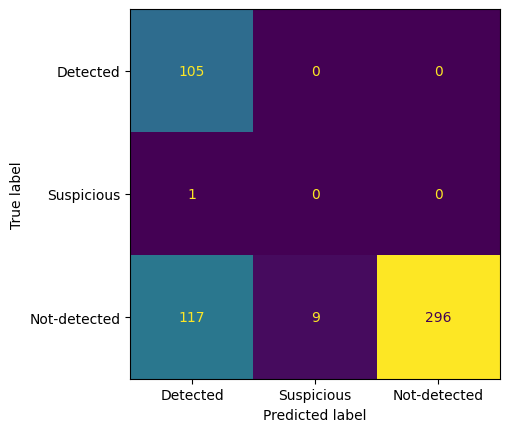

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat_lda = confusion_matrix(peak_info['interp'].astype('string'), pred_lda, labels=["1.0","0.5","0.0"])
disp_lda = ConfusionMatrixDisplay(conf_mat_lda, display_labels=["Detected","Suspicious","Not-detected"])
disp_lda.plot(colorbar=False)

In [ ]:
# Save predictions
prediction_table = pd.concat([peak_info, pd.DataFrame({'PredictionsLDA': pred_lda})], axis=1)

prediction_table.to_csv("prediction_batch.csv", index=False)